# LangSmith Evaluate LLM 기초예제
## 작성자 : AISchool ( http://aischool.ai/%ec%98%a8%eb%9d%bc%ec%9d%b8-%ea%b0%95%ec%9d%98-%ec%b9%b4%ed%85%8c%ea%b3%a0%eb%a6%ac/ )
## Reference : https://docs.smith.langchain.com/tutorials/Developers/evaluation

**어플리케이션의 성능을 당신이나 사용자에게 중요한 기준에 따라 측정하는 것**은 어려울 수 있습니다. 그러나 **이를 수행하는 것은 특히 어플리케이션을 반복적으로 개선해 나갈 때 매우 중요**합니다.

이 가이드에서는 어플리케이션을 테스트하고 평가하는 방법에 대해 다룹니다. 이를 통해 고정된 데이터 세트에 대해 어플리케이션이 얼마나 잘 수행되고 있는지 측정할 수 있습니다. 이러한 인사이트를 신속하고 신뢰성 있게 얻을 수 있다면, 자신감을 가지고 반복적으로 개선해 나갈 수 있을 것입니다.


이 튜토리얼에서는 다음과 같은 내용을 다룰 것입니다:


*   성능을 측정하기 위한 초기 골든 데이터셋을 생성하는 방법
*   성능을 측정하기 위한 지표를 정의하는 방법
*   다양한 프롬프트나 모델에 대한 평가를 실행하는 방법
*   결과를 수동으로 비교하는 방법

LangSmith가 지원하는 평가 워크플로우에 대한 자세한 내용은 가이드( https://docs.smith.langchain.com/how_to_guides )에서 확인할 수 있습니다.

# 라이브러리 설치

In [ ]:
!pip install --upgrade --quiet  langchain langsmith langchainhub langchain-openai tiktoken
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 557.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.2/140.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.0/384.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.4/360.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.

# LangSmith Key 설정

In [ ]:
import os
from uuid import uuid4

unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Evaluate your LLM application - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "여러분의_LANGCHAIN_API_KEY"

# Create a dataset

어플리케이션을 테스트하고 평가할 준비를 할 때 첫 번째 단계는 평가하려는 데이터 포인트를 정의하는 것입니다. 여기서 고려해야 할 몇 가지 측면이 있습니다:

*   각 데이터 포인트의 스키마는 어떻게 설정해야 할까요?
*   얼마나 많은 데이터 포인트를 수집해야 할까요?
*   이러한 데이터 포인트를 어떻게 수집해야 할까요?

**스키마(Schema)**: 각 데이터 포인트는 최소한 어플리케이션에 입력되는 데이터를 포함해야 합니다. 가능하다면 예상 출력값도 정의하는 것이 매우 유용합니다. 이는 제대로 작동하는 어플리케이션이 출력해야 할 결과를 나타냅니다. 완벽한 출력을 정의할 수 없는 경우가 많습니다만, 그것은 괜찮습니다! 평가는 반복적인 과정입니다. 때로는 예를 들어, RAG에서 가져올 예상 문서나 에이전트로서 수행해야 할 예상 단계와 같은 더 많은 정보를 각 예제에 대해 정의하고 싶을 수도 있습니다. LangSmith 데이터셋은 매우 유연하여 임의의 스키마를 정의할 수 있습니다.

**데이터 포인트 수(How many)**: 수집해야 할 데이터 포인트의 수에 대한 엄격한 규칙은 없습니다. 중요한 것은 방어하고자 하는 경계 사례에 대한 적절한 커버리지를 확보하는 것입니다. 심지어 10-50개의 예제만으로도 큰 가치를 제공할 수 있습니다! 처음부터 많은 수를 모으는 것에 대해 걱정하지 마세요. 시간에 따라 추가해 나가면 됩니다.

**수집 방법(How to get)**: 이것이 아마도 가장 까다로운 부분일 것입니다. 데이터셋을 수집하기로 결정했다면, 실제로 어떻게 시작해야 할까요? 대부분의 새로운 프로젝트를 시작하는 팀은 보통 첫 10-20개의 데이터 포인트를 수작업으로 수집합니다. 이 데이터 포인트들로 시작한 후, 이러한 데이터셋은 일반적으로 살아있는 구성물이며 시간이 지남에 따라 성장합니다. 일반적으로 실제 사용자가 어플리케이션을 사용하는 방법을 보고, 존재하는 문제점을 파악한 후, 그 중 몇 가지를 이 세트에 추가하면서 데이터셋이 확장됩니다. 또한 데이터셋을 증강하기 위해 합성 데이터를 생성하는 방법도 있습니다. **처음에는 이러한 방법에 대해 걱정하지 말고 약 10-20개의 예제를 수작업으로 라벨링하는 것을 권장**합니다.








데이터셋을 준비한 후에는 이를 LangSmith에 업로드하는 몇 가지 방법이 있습니다. 이 튜토리얼에서는 클라이언트를 사용할 것이지만, UI를 통해 업로드하거나 UI에서 직접 생성할 수도 있습니다.

이 튜토리얼에서는 평가를 위해 5개의 데이터 포인트를 생성할 것입니다. 우리는 질문-답변 어플리케이션을 평가할 예정입니다. 입력은 질문이 되고, 출력은 답이 될 것입니다. 질문-답변 어플리케이션이므로 예상 답변을 정의할 수 있습니다. 이제 이 데이터셋을 LangSmith에 생성하고 업로드하는 방법을 보여드리겠습니다!

In [ ]:
from langsmith import Client

client = Client()

# Define dataset: these are your test cases
dataset_name = "QA Example Dataset"
dataset = client.create_dataset(dataset_name)
client.create_examples(
    inputs=[
        {"question": "What is LangChain?"},
        {"question": "What is LangSmith?"},
        {"question": "What is OpenAI?"},
        {"question": "What is Google?"},
        {"question": "What is Mistral?"},
    ],
    outputs=[
        {"answer": "A framework for building LLM applications"},
        {"answer": "A platform for observing and evaluating LLM applications"},
        {"answer": "A company that creates Large Language Models"},
        {"answer": "A technology company known for search"},
        {"answer": "A company that creates Large Language Models"},
    ],
    dataset_id=dataset.id,
)

이제 LangSmith UI로 이동하여 "Datasets & Testing" 페이지에서 "QA Example Dataset"을 찾으면, 해당 항목을 클릭했을 때 다섯 개의 새로운 예제가 추가된 것을 확인할 수 있을 것입니다.

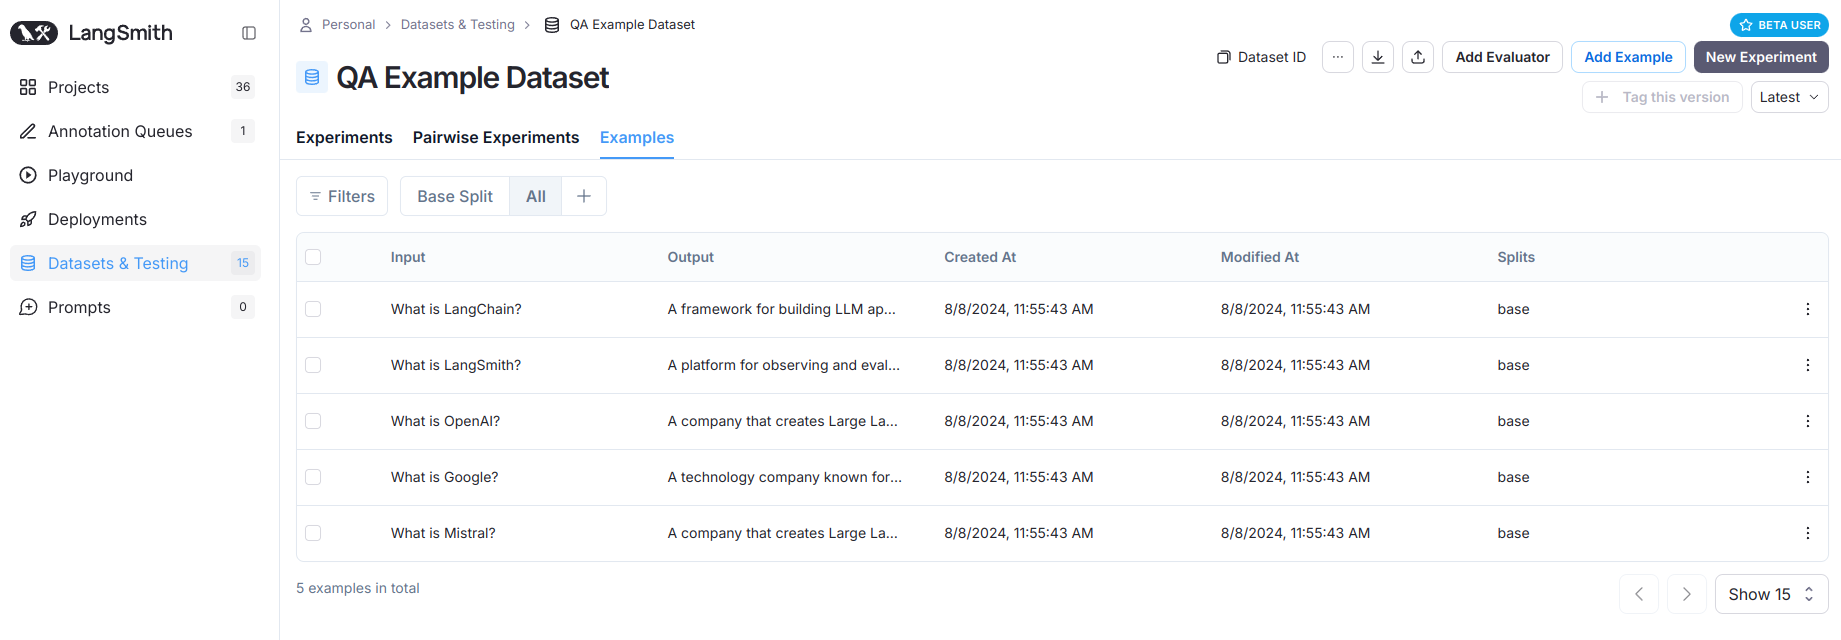

# Define metrics

데이터셋을 생성한 후, 이제 응답을 평가할 몇 가지 지표를 정의할 수 있습니다. 예상 답변이 있기 때문에, 이를 평가의 일환으로 비교할 수 있습니다. **그러나 어플리케이션이 정확히 동일한 답변을 출력하기보다는 유사한 답변을 출력할 것으로 예상됩니다. 이는 평가를 다소 까다롭게 만듭니다.**

**정확성을 평가하는 것 외에도, 답변이 짧고 간결한지 확인해 보겠습니다. 이것은 조금 더 쉬울 것입니다. 응답의 길이를 측정하는 간단한 Python 함수를 정의**할 수 있습니다.

이 두 가지 지표를 정의해 보겠습니다.

첫 번째로, **출력이 (예상 출력과 비교하여) 올바른지 판단하기 위해 LLM을 사용할 것입니다. LLM을 판사로 사용하는 것은 간단한 함수로 측정하기 어려운 복잡한 경우에 비교적 흔한 방법**입니다. 여기에서 평가를 위해 사용할 프롬프트와 LLM을 정의할 수 있습니다.

## OpenAI API Key 설정

In [ ]:
# Used by the agent in this tutorial
os.environ["OPENAI_API_KEY"] = "여러분의_OPENAI_API_KEY"

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts.prompt import PromptTemplate
from langsmith.evaluation import LangChainStringEvaluator

_PROMPT_TEMPLATE = """You are an expert professor specialized in grading students' answers to questions.
You are grading the following question:
{query}
Here is the real answer:
{answer}
You are grading the following predicted answer:
{result}
Respond with CORRECT or INCORRECT:
Grade:
"""

PROMPT = PromptTemplate(
    input_variables=["query", "answer", "result"], template=_PROMPT_TEMPLATE
)
eval_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm, "prompt": PROMPT})

응답 길이를 평가하는 것은 훨씬 간단합니다! **실제 출력이 예상 결과의 길이의 2배 미만인지 확인하는 간단한 함수를 정의**하기만 하면 됩니다.

In [ ]:
from langsmith.schemas import Run, Example

def evaluate_length(run: Run, example: Example) -> dict:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("answer") or ""
    score = int(len(prediction) < 2 * len(required))
    return {"key":"length", "score": score}

# Run Evaluations

좋습니다! 이제 평가를 어떻게 실행할까요? 데이터셋과 평가자를 준비했으니, 이제 필요한 것은 우리의 어플리케이션입니다! 우리는 간단한 어플리케이션을 구축할 것인데, 이 어플리케이션은 **응답하는 방법에 대한 지침이 포함된 시스템 메시지**를 가지고 있으며, 이를 LLM에 전달합니다. 이를 OpenAI SDK를 사용하여 직접 구축할 것입니다.

In [ ]:
import openai

openai_client = openai.Client()

def my_app(question):
    return openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "Respond to the users question in a short, concise manner (one short sentence)."
            },
            {
                "role": "user",
                "content": question,
            }
        ],
    ).choices[0].message.content

LangSmith 평가를 통해 이것을 실행하기 전에, 데이터셋의 입력 키를 우리가 호출하려는 함수에 매핑하고, 함수의 출력을 예상되는 출력 키에 매핑하는 간단한 래퍼를 정의해야 합니다.

In [ ]:
def langsmith_app(inputs):
    output = my_app(inputs["question"])
    return {"output": output}

좋습니다! 이제 평가를 실행할 준비가 되었습니다. 시작해 봅시다!


In [ ]:
from langsmith.evaluation import evaluate

experiment_results = evaluate(
    langsmith_app, # Your AI system
    data=dataset_name, # The data to predict and grade over
    evaluators=[evaluate_length, qa_evaluator], # The evaluators to score the results
    experiment_prefix="openai-3.5", # A prefix for your experiment names to easily identify them
)

View the evaluation results for experiment: 'openai-3.5-1d6c7e60' at:
https://smith.langchain.com/o/2da4358c-aaa8-5f93-b4af-fa2d78b96bd8/datasets/3dcc9dec-82fe-4cc0-90ee-966e4401a289/compare?selectedSessions=26ba3d18-4b84-4692-9156-5eeffc1da221




0it [00:00, ?it/s]

이 작업은 URL을 출력할 것입니다. 해당 URL을 클릭하면 평가 결과를 확인할 수 있습니다!

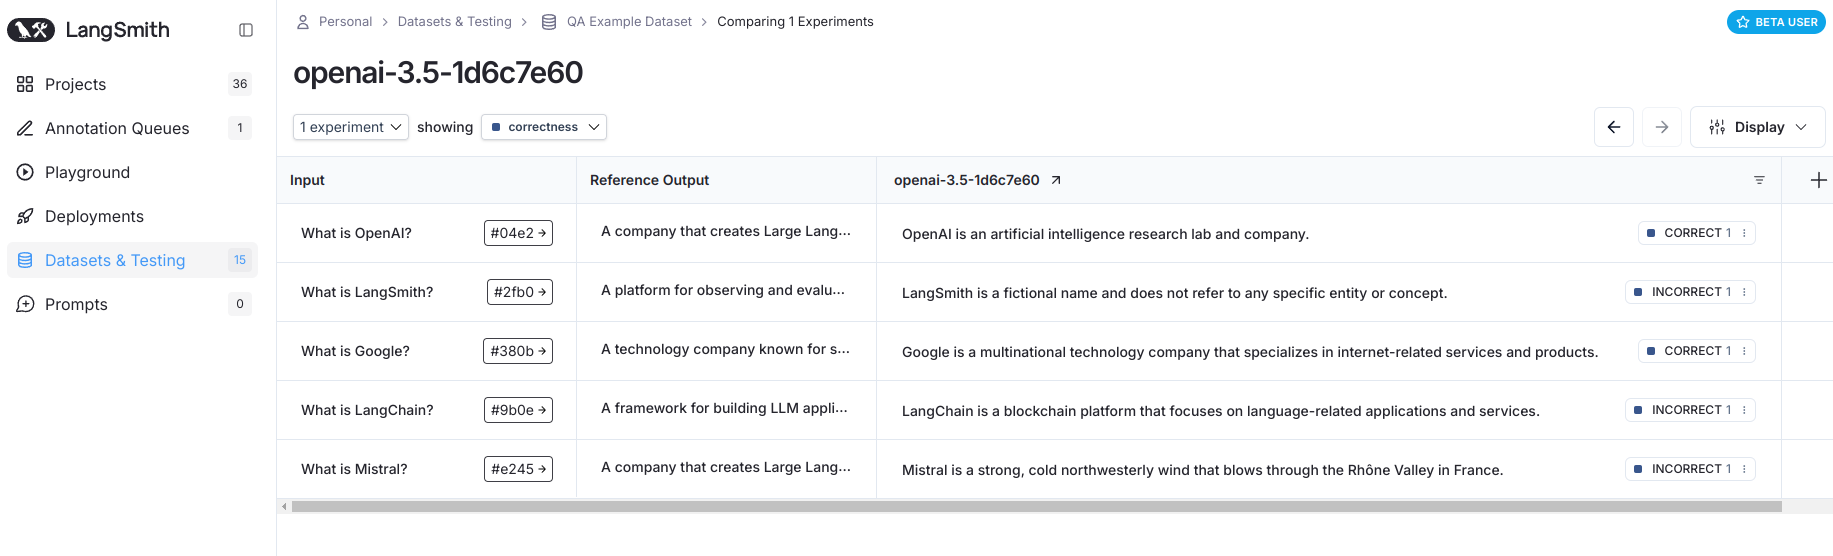

데이터셋 페이지로 돌아가서 "Experiments" 탭을 선택하면, 이제 우리가 실행한 한 번의 평가 요약을 확인할 수 있습니다!


**이제 다른 모델로 시도해 봅시다! 이번에는 gpt-4-turbo를 사용**해 보겠습니다.


In [ ]:
import openai

openai_client = openai.Client()

def my_app_1(question):
    return openai_client.chat.completions.create(
        model="gpt-4-turbo",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "Respond to the users question in a short, concise manner (one short sentence)."
            },
            {
                "role": "user",
                "content": question,
            }
        ],
    ).choices[0].message.content


def langsmith_app_1(inputs):
    output = my_app_1(inputs["question"])
    return {"output": output}

from langsmith.evaluation import evaluate

experiment_results = evaluate(
    langsmith_app_1, # Your AI system
    data=dataset_name, # The data to predict and grade over
    evaluators=[evaluate_length, qa_evaluator], # The evaluators to score the results
    experiment_prefix="openai-4", # A prefix for your experiment names to easily identify them
)

View the evaluation results for experiment: 'openai-4-c8399c1a' at:
https://smith.langchain.com/o/2da4358c-aaa8-5f93-b4af-fa2d78b96bd8/datasets/3dcc9dec-82fe-4cc0-90ee-966e4401a289/compare?selectedSessions=5bd96896-7396-4746-b612-9cc6e595e733




0it [00:00, ?it/s]

이제 GPT-4를 사용하되, **답변이 짧아야 한다는 요구사항을 좀 더 엄격하게 하는 프롬프트로 업데이트**해 봅시다.








In [ ]:
import openai

openai_client = openai.Client()

def my_app_2(question):
    return openai_client.chat.completions.create(
        model="gpt-4-turbo",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "Respond to the users question in a short, concise manner (one short sentence). Do NOT use more than ten words."
            },
            {
                "role": "user",
                "content": question,
            }
        ],
    ).choices[0].message.content


def langsmith_app_2(inputs):
    output = my_app_2(inputs["question"])
    return {"output": output}

from langsmith.evaluation import evaluate

experiment_results = evaluate(
    langsmith_app_2, # Your AI system
    data=dataset_name, # The data to predict and grade over
    evaluators=[evaluate_length, qa_evaluator], # The evaluators to score the results
    experiment_prefix="strict-openai-4", # A prefix for your experiment names to easily identify them
)

View the evaluation results for experiment: 'strict-openai-4-9acbbc81' at:
https://smith.langchain.com/o/2da4358c-aaa8-5f93-b4af-fa2d78b96bd8/datasets/3dcc9dec-82fe-4cc0-90ee-966e4401a289/compare?selectedSessions=e509db7e-fa43-4296-836c-982113dcf67e




0it [00:00, ?it/s]

데이터셋 페이지의 "Experiments" 탭으로 돌아가면, 이제 세 번의 실행 결과가 모두 표시된 것을 확인할 수 있을 것입니다!

# Comparing results


멋집니다, 세 번의 실행을 평가했습니다. 하지만 결과를 어떻게 비교할 수 있을까요? 첫 번째 방법은 "Experiments" 탭에서 실행 기록을 살펴보는 것입니다. 그렇게 하면 각 실행에 대한 지표를 높은 수준에서 볼 수 있습니다.








좋습니다! **이제 GPT-4가 회사 정보를 아는 데 있어서 GPT-3.5보다 더 뛰어나다는 것을 알 수 있고, 엄격한 프롬프트가 응답 길이에 크게 도움이 되었다는 것도 확인**할 수 있습니다.